## Imports

In [17]:
#Versión para tweepy V2
from datetime import date
import datetime
import requests
import json
import time
from pathlib import Path
import math
import pymongo
from bson import ObjectId
import numpy as np
from datetime import date
import os
import sys
import matplotlib.pyplot as plt

## Constant and Variables

In [18]:
# CONSTANTS
PETITIONS_PER_TIME_LAPSE = 300
TIME_LAPSE = 20*60
# Tiempo de espera necesario entre peticiones
TIMER = TIME_LAPSE/PETITIONS_PER_TIME_LAPSE
# Log cada 5 minutos
TIMER_LOG = 5*60
#porcentaje de tweets que nos quedamos para cada dia
PERCENT = 0.15
# máximo de tweets por cada petición
PETITIONS_LIMIT = 500

#VARIABLES
iniTimerLog = 0
finTimerLog = 0
tiempo = TIMER_LOG
hashtagsList = []
hashtags = []
entrada = ""
next_token = None
entradaizq = '' 
entradader = ''
total = 0
startDate = ''
endDate = ''
inicio = 0
fin = 0
hashtag_ini_log = ''
start_log_timer = ''
hashtag_last_log = ''
tweet_count = 0
url = 'https://api.twitter.com/2/tweets/search/all?'
today = datetime.date.today()
d1 = today.strftime("%d-%m-%Y")

## Dictionaries

In [19]:
user_dictionary = {
    "_id"               : None,
    "description"       : '',
    "created_at"        : '',
    "verified"          : '',
    "followers_count"   : 0,
    "following_count"   : 0
}


tweet_dictionary = {
    "_id"               : None,
    "author_id"         : '',
    "created_at"        : '',
    "text"              : '',
    "hashtag"           : [],
    "referenced_tweets" : [],
    "retweet_count"     : 0,
    "reply_count"       : 0,
    "reply_count"       : 0,
    "like_count"        : 0
}


node = {
    "hashtag"           : '',
    "current_date"        : '',
    "next_date"        : '',
    "next_token"        : '-1'
}

## Support functions

In [20]:
def DayMonthYearToPetition(date):
    """
    """
    splited = ''
    if ('/' in date):
        splited = date.split('/')
    elif ('-' in date):
        splited = date.split('-')
        
    return (splited[2] + '-' + splited[1] + '-' + splited[0])

def DayMonthYearToPetition(date):
    """
    """
    splited = ''
    if ('/' in date):
        splited = date.split('/')
    elif ('-' in date):
        splited = date.split('-')

    return (splited[2] + '-' + splited[1] + '-' + splited[0])

def PetitionToDayMonthYear(petition):
    """
    """
    splited = ''
    time = ''
    splited = petition.split('T')
    time = splited[1]
    splited = splited[0].split('-')
    return (splited[2] + '-' + splited[1] + '-' + splited[0] + 'T' + time)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None

def create_headers(bearer_token):
    """
    """
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

def connect_to_endpoint(headers, params):
    """
    """
    global d1
    response = requests.request("GET", "https://api.twitter.com/2/tweets/search/all?", headers=headers, params=params, timeout=2)
    # Manejo de errores
    if response.status_code != 200:
        # datetime object containing current date and time
        now = datetime.datetime.now()
        # dd/mm/YY H:M:S
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        errorlog = open("./errorlog" + d1 + ".txt", "a")
        errorlog.write("Error en respuesta: " + str(response.status_code) + ', ' + str(response.text) + " " + dt_string + "\n")
        errorlog.close()
    return response.json()


def TestInsertion(tweet_list, user_list):
    global myclient
    global myusers
    global mytweets
    global mydb
    
    aux = []
    [aux.append(t["_id"]) for t in tweet_list]
    if len(list(mytweets.find( { "_id" : {"$in" : aux } }))) != len(aux):
        print("lista encontrados: ", len(list(mytweets.find( { "_id" : {"$in" : aux } }))), " lista real: ", len(aux))
        print('Not working propperly')
        sys.exit()
        
    aux = []
    [aux.append(u["_id"]) for u in list(user_list)]   
    aux = list(set(aux))
    if len(list(myusers.find( { "_id" : {"$in" : aux } }))) != len(aux):
        print("lista encontrados: ", len(list(myusers.find( { "_id" : {"$in" : aux } }))), " lista real: ", len(aux))
        print('Not working propperly')
        print('Not working propperly')
        sys.exit()
    
    
def MongoExecute(tweet_list, user_list):
    """
        tweet_list: lista de tweets que se van a insertar en la base de datos
        user_list: lista de usuarios que se van a insertar en la base de datos
    """
    global myclient
    global myusers
    global mytweets
    global mydb
    
    try:
        print(str(mytweets.insert_many(tweet_list, ordered=False)))
    except Exception as e:        
        pass
    try:
        print(str(myusers.insert_many(user_list, ordered=False)))
    except Exception as e:        
        pass
    
    TestInsertion(tweet_list, user_list)

def PrintTweetsUsers(tweets, users):
    print("Tweet list")
    for tweet in tweets:
        print(" id: " + str(tweet['_id']))
        print(" author_id: " + tweet['author_id'])
        print(" created_at: " + tweet['created_at'])
        print(" referenced_tweets: " + str(tweet['referenced_tweets']) + '\n')

    print("User list")
    for user in users:
        print(" user_id: " + str(user['_id']))
        print(" description: " + user['description'])
        print(" created_at: " + user['created_at'])
        print(" verified: " + str(user['verified']))
        print(" followers_count: " + str(user['followers_count']))
        print(" following_count: " + str(user['following_count']) + '\n')

        
def Init_Tweet_Dictionary():
    tweet_dictionary_new = tweet_dictionary.copy()
    tweet_dictionary_new['hashtag'] = []
    tweet_dictionary_new['referenced_tweets'] = []
    return tweet_dictionary_new

def Tweet_to_Dictionary(tweet):
    tweet_dictionary_new = Init_Tweet_Dictionary()
    tweet_dictionary_new['_id'] = make_objid(str(tweet['id']))
    tweet_dictionary_new['author_id'] = make_objid(str(tweet['author_id']))
    tweet_dictionary_new['text'] = tweet['text']
    tweet_dictionary_new['created_at'] = tweet['created_at']
    tweet_dictionary_new['retweet_count'] = tweet['public_metrics']['retweet_count']
    tweet_dictionary_new['reply_count'] = tweet['public_metrics']['reply_count']
    tweet_dictionary_new['like_count'] = tweet['public_metrics']['like_count']
    tweet_dictionary_new['quote_count'] = tweet['public_metrics']['quote_count']

    # Inserci'on de hashtags del tweet para los casos de tweets sin referencias, quotes o respuestas
    if "entities" in tweet and "hashtags" in tweet["entities"]:
        [tweet_dictionary_new['hashtag'].append(h['tag'].upper()) for h in tweet["entities"]["hashtags"]]
    return tweet_dictionary_new

def IsUnknown(user_id, user_list):
    for user in user_list:
        if (str(user['_id']) == str(user_id)):
            return False
    return True
        
def PetitionsLessEqualPETITIONS_LIMIT(hashtag, start, end, bearer, next_token):
    '''
        Hashtag: nombre del hashtag que se va a buscar
        start: fecha de inicio
        end: fecha de respuesta
        number: n'umero de tweets que queremos obtener
        bearer: bearer id
        next_token: token de la page (inicialmente string vac'ia) que quieres buscar
        return: tupla de n'umero de respuestas y next_token
    '''
    global headers
    global PETITIONS_LIMIT
    global hashtagsList
    global hashtags
    global d1

    startDate = DayMonthYearToPetition(start)
    endDate = DayMonthYearToPetition(end)
    tweet_list = []
    user_list = []
    total = (0, '', [], [])
    dt_string = ''
    tweet_dictionary_new = {}
    user_dictionary_new = {}
    aux = ''
    
    """
     Insertados los siguientes campos:
        -start_time: límite inferior en búsqueda de fechas
        -end_time: límete superior en búsqueda de fechas
        -tweet.fields=author_id: id del autor del tweet
        -tweet.fields=referenced_tweets: puede ser quote, retweet o replied_to junto al id al que responde, agrega además los tweets relativos al tweet al que responde
        -tweet.fields=created_at: cu'ando se cre'o el fichero
        -tweet.fields=context_annotations:anotaciones de contexto (no salen muchas)
        -tweet.fields=lang: Abreviatura del idioma en el que se escribe
        -tweet.fields=entities: referencias, hashtags usados por el usuario
        -tweet.fields=in_reply_to_user_id: 
        -tweet.fields=conversation_id: 
        -tweet.fields=public_metrics:
        -tweet.fields=text:
        -tweet.fields=entities:
        -expansions=author_id
        -expansions=referenced_tweets.id
        -expansions=author_id,referenced_tweets.id
        -user.fields=created_at
        -user.fields=entities
        -user.fields=description
        -user.fields=verified
        -user.fields=public_metrics
    """
    params = "query=%23" + hashtag + "&start_time=" +  startDate + "T00%3A00%3A00Z" + "&end_time=" + endDate + 'T11%3A59%3A59Z&max_results=' + str(PETITIONS_LIMIT) + "&expansions=author_id,referenced_tweets.id&tweet.fields=created_at,conversation_id,referenced_tweets,public_metrics,text,entities&user.fields=created_at,entities,description,verified,public_metrics"

    # caso en el que -1 (primera peticion de dia) o es el next_token
    if (next_token != ''):
        params = params + '&next_token=' + next_token
        
    json_obj = ''
    try:
        json_obj = connect_to_endpoint(headers=headers, params=params)
    # Caso en el que falla el conect to endpoint
    except Exception as e:
        print(e)
        return (0, next_token, [], [])
    
    # Comprobar que hay respuestas para dicho hashtag
    if ('meta' in json_obj) and (int(json_obj['meta']['result_count']) > 0):
        # Iteraci'on lista de objetos tweets
        for tweet in json_obj['data']:
            # Inicializar dictionary de tweet
            tweet_dictionary_new = Tweet_to_Dictionary(tweet)
            # Inserci'on de los tweets referidos en la lista de tweets referedios con sus object id
            if ('referenced_tweets' in tweet):
                tweet_dictionary_new['referenced_tweets'] = tweet['referenced_tweets']
                for rt in tweet_dictionary_new['referenced_tweets']:
                    for tweetexpanse in json_obj['includes']['tweets']:
                        if (rt['id'] == tweetexpanse['id']):
                            rt['author_id'] = make_objid(str(tweetexpanse['author_id']))
                            rt['id'] = make_objid(str(tweetexpanse['id']))
                            break   
                            
            if (IsUnknown(tweet_dictionary_new['author_id'], user_list) == True):
                if ('includes' in json_obj):
                    for user in json_obj['includes']['users']:
                        if str(make_objid(user['id'])) == str(tweet_dictionary_new['author_id']):
                            # Inicializar dictionary de usuarios                
                            user_dictionary_new = user_dictionary.copy()
                            
                            user_dictionary_new['_id'] = tweet_dictionary_new['author_id']
                            user_dictionary_new['description'] = user['description']
                            user_dictionary_new['created_at'] = user['created_at']
                            user_dictionary_new['verified'] = user['verified']
                            user_dictionary_new['followers_count'] = int(user['public_metrics']['followers_count'])
                            user_dictionary_new['following_count'] = int(user['public_metrics']['following_count'])
                            user_list.append(user_dictionary_new)
                            break
                else:
                    # datetime object containing current date and time
                    now = datetime.datetime.now()
                    # dd/mm/YY H:M:S
                    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
                    errorlog = open("./errorlog" + d1 + ".txt", "a")
                    errorlog.write("El formato del mensaje recibido no es el correcto" + dt_string + "\n")
                    errorlog.close()
            
            tweet_list.append(tweet_dictionary_new)

        if ('next_token' in json_obj['meta']):
            total = (int(json_obj['meta']['result_count']), json_obj['meta']['next_token'], tweet_list, user_list)
        else:
            total = (int(json_obj['meta']['result_count']), '', tweet_list, user_list)

        print("     N'umero de peticiones enviadas: " + str(PETITIONS_LIMIT))
        print("     N'umero de peticiones recibidas: " + str(json_obj['meta']['result_count']))
        return total
    # caso en el que la respuesta es vac'ia o un error.
    else:    
        total = (0, next_token, [], [])
    return total

def TweetList(hashtag, start, end, bearer, token):
    '''
        hashtag: nombre del hashtag que se va a buscar
        start: fecha de inicio
        end: fecha de respuesta
        number: n'umero de tweets que queremos obtener
        bearer: bearer id
        return devuelve dos diccionarios (users-tweet, tweet-tweet_items)
    '''
    global tiempo
    global TIMER
    global TIMER_LOG
    global tweet_count
    global hashtag_ini_log
    global hashtag_last_log
    global start_log_timer
    global d1
    

    #aqui deberia de hacer dos variables de incio y fin de log para saber con cual hashtag empiezo y termino y con cuantos valores totales de cada uno.QUITAR TWEETLIST
    total = 0
    aux = 0
    startTime = 0
    endTime = 0
    response = (0, token, [], [])

    startTime = time.time()
    response =  PetitionsLessEqualPETITIONS_LIMIT(hashtag, start, end, bearer, response[1])
        
    total = response[0]
    tweet_count += response[0]
    endTime = time.time()

    aux = truncate(endTime - startTime)
    if (aux < TIMER):
        number = TIMER - aux
        time.sleep(number)
        tiempo -= TIMER
    else:
        tiempo -= aux
    
    if (tiempo <= 0):
        #aqui se imprime en el log los hashtags que se han escrito y c'uantos valores se han obtenido de estos
        tiempo = TIMER_LOG
        now = datetime.datetime.now()
        # dd/mm/YY H:M:S
        dt_string = now.strftime("%H:%M:%S")
        hashtag_last_log = hashtag
        log = open("./log" + d1 + ".txt", "a")
        log.write(hashtag_ini_log + ' ' + start_log_timer + ' ' + hashtag + ' ' + start + ' ' + dt_string + '\n')
        log.close()
        start_log_timer = dt_string
        tweet_count = 0
        hashtag_ini_log = hashtag_last_log
        
    return (total, response[1], response[2], response[3])

def InitHashtagsListLastToken(start_date, end_date):
    '''
        start_date: D'ia de inicializaci'on del algoritmo
        end_date: D'ia de finalizaci'on del algoritmo
        return: lista de tuplas (hashtag, next_token, current_date, next_date)
    '''
    global d1
    
    aux = []
    
    if os.path.exists("./lasttoken.txt") and os.path.getsize("./lasttoken.txt") > 0:
        f =  open("./lasttoken.txt", "r")
        hashtag = ''
        while True:
            # read line
            try:
                hashtag = f.readline()
                if (hashtag == "") :
                    break
            except:
                # datetime object containing current date and time
                now = datetime.datetime.now()
                # dd/mm/YY H:M:S
                dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
                errorlog = open("./errorlog" + d1 + ".txt", "a")
                errorlog.write("Fallo al leer el fichero hashtags.txt " + dt_string + "\n")
                errorlog.close()
            hashtag = hashtag.rstrip('\n')
            hashtag = hashtag.split(' ')
            node_aux = node.copy()
            node_aux['hashtag'] = hashtag[0].upper()
            node_aux['next_token'] = hashtag[1]
            node_aux['current_date'] = hashtag[2]
            node_aux["next_date"] = hashtag[3]  
            aux.append(node_aux)
        f.close()

        fd=open("./lasttoken.txt","r")
        d=fd.read()
        fd.close()
        m=d.split("\n")
        s="\n".join(m[:-1])

        fd=open("./lasttoken.txt","w+")
        for i in range(len(s)):
            fd.write(s[i])
        fd.close()
        
    else:
        #####Uso de Hashtag
        f =  open("./hashtags.txt", "r")
        d =  open("./lasttoken.txt", "w+")
        hashtag = None
        writeable = ''
        resultado = (0, '', [], [])
        first = start_date.split('-')
        dat = date(int(first[2]), int(first[1]), int(first[0]))
        first_day = dat
        dat += datetime.timedelta(days=1)
        next_day = dat
        str_first_day = first_day.strftime("%d/%m/%Y")
        str_next_day = next_day.strftime("%d/%m/%Y")
        while True:
            # read line
            try:
                hashtag = f.readline()
                if (hashtag == "") :
                    break
            except:
                # datetime object containing current date and time
                now = datetime.datetime.now()
                # dd/mm/YY H:M:S
                dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
                errorlog = open("./errorlog" + d1 + ".txt", "a")
                errorlog.write("Fallo al leer el fichero hashtags.txt " + dt_string + "\n")
                errorlog.close()
            
            hashtag = hashtag.rstrip('\n')
            hashtag = hashtag.replace('#', '')
            
            node_aux = node.copy()
            node_aux["hashtag"] = hashtag
            writeable = hashtag

            writeable += ' ' + node_aux['next_token']

            node_aux["current_date"] = str_first_day   
            writeable += ' ' + str_first_day 

            node_aux["next_date"] = str_next_day 
            writeable += ' ' + str_next_day + '\n'   

            aux.append(node_aux)
            d.write(writeable)
        d.close()
    f.close()
    return aux

def NextDate(current_date):
    '''
        current_date: D'ia de entrada
        return: Devuelve el d'ia siguiente al d'ia actual
    '''
    dat = datetime.datetime.strptime(current_date, "%d/%m/%Y")
    dat += datetime.timedelta(days=1)
    return dat.strftime("%d/%m/%Y").split(' ')[0]

def truncate(n):
    s = str(float(n)).split('.')
    return int(s[0])

def GetTweets(start_date, end_date):
    '''
        start_date: D'ia de entrada
        end_date: Devuelve el d'ia siguiente al d'ia actual
    '''
    global tiempo
    global TIMER
    global TIMER_LOG
    global tweet_count
    global hashtags
    global d1

    aux = end_date.split('-')
    last_date = date(int(aux[2]), int(aux[1]), int(aux[0]))
    last_date = last_date.strftime("%d/%m/%Y")

    f =  open("./hashtags.txt", "r")
    hashtags = f.readlines()
    f.close()
    
    
    hashtagsList = InitHashtagsListLastToken(start_date, end_date)
        

    for h in hashtagsList:
        print(str(h))
        

    if (len(hashtagsList) != 0):
        hashtag_ini_log = hashtagsList[0]
        # dd/mm/YY H:M:S
        now = datetime.datetime.now()
        dt_string = now.strftime("%H:%M:%S")
        start_log_timer = dt_string
        
    else:
        # datetime object containing current date and time
        now = datetime.datetime.now()
        # dd/mm/YY H:M:S
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        errorlog = open("./errorlog" + d1 + ".txt", "a")
        errorlog.write("Error: lista de hashtags vacía" + " dt_string\n")
        errorlog.close()

    count = 0
    temporalTokens = ''
    tweet_list = []
    user_list = []
    start = 0
    end = 0
    
    last = False
    while hashtagsList[len(hashtagsList) - 1]['current_date'] != last_date:
        for l in hashtagsList:
            if l['current_date'] != last_date:
                start = 0
                end = 0
                aux = 0
                #bucle de obtencion de tweets para un dia concreto
                while (l["next_token"] != ''):
                    if l["next_token"] == '-1':
                        print('Inicio hashtag: ' + l['hashtag'] + ' día: ' + l['current_date'])
                        resultado = TweetList(l["hashtag"], l["current_date"], l["next_date"], Bearer, '')
                    else:
                        resultado = TweetList(l["hashtag"], l["current_date"], l["next_date"], Bearer, l["next_token"])
                        
                    start = time.time()
                    tweet_list.extend(resultado[2])
                    user_list.extend(resultado[3])
                    l["next_token"] = resultado[1]
                    end = time.time()

                    tiempo -= truncate(start - end)

                    if (tiempo <= 0):
                        # datetime object containing current date and time
                        tiempo = TIMER_LOG
                        now = datetime.datetime.now()
                        # dd/mm/YY H:M:S
                        dt_string = now.strftime("%H:%M:%S")
                        log = open("./log" + d1 + ".txt", "a")
                        log.write(hashtag_ini_log + ' ' + start_log_timer + ' ' + l['hashtag'] + ' ' + l['current_date'] + ' ' + dt_string + '\n')
                        log.close()
                        hashtag_ini_log = l['hashtag']

                start = time.time()
                # Substring de % para insertar en la base de datos
                count = 0
                count = truncate(math.ceil(len(tweet_list) * PERCENT))
                if len(tweet_list) > 0:
                    if count > 0:
                        tweet_list = tweet_list[0:count]
                    else:
                        tweet_list = list(tweet_list[0])
                    aux_list = []
                    # Ahora buscamos los users relacionados con los tweets de la lista
                    for t in tweet_list:
                        for u in user_list:
                            if (str(t['author_id']) == str(u['_id'])):
                                aux_list.append(u)
                                break 
                    MongoExecute(tweet_list, aux_list)

                #ahora cambiamos de d'ia y quitamos la lista
                tweet_list = []
                user_list = []
                print('Fin hashtag: ' + l['hashtag'] + ' día: ' + l['current_date'])
                l['current_date'] = l['next_date']
                l['next_date'] = NextDate(l['current_date'])
                l['next_token'] = '-1'
                
                #borramos la 'ultima linea de fichero de lasttoken
                if os.path.exists("./lasttoken.txt") and os.path.getsize("./lasttoken.txt") > 0:
                    d = ''
                    f =  open("./lasttoken.txt", "r")
                    #remove last line from a text line in python
                    d = f.readlines()
                    f.close()

                    for i in range(len(d)):
                        if d[i].split()[0] == l['hashtag']:
                            if (l['current_date'] != last_date):
                                d[i] = l['hashtag'] + ' ' + l['next_token'] + ' ' + l['current_date'] + ' ' + l["next_date"] + '\n'
                                break
                            else:
                                d[i] = ''
                                break

                    f = open("./lasttoken.txt","w+")
                    f.writelines(d)
                    f.close()

                end = time.time()

                tiempo -= truncate(start - end)
                if (tiempo <= 0):
                    # datetime object containing current date and time
                    tiempo = TIMER_LOG
                    now = datetime.datetime.now()
                    # dd/mm/YY H:M:S
                    dt_string = now.strftime("%H:%M:%S")
                    log = open("./log" + d1 + ".txt", "a")
                    log.write(hashtag_ini_log + ' ' + start_log_timer + ' ' + l['hashtag'] + ' ' + l['current_date'] + ' ' + dt_string + '\n')
                    log.close()
                    hashtag_ini_log = l['hashtag']
                    
            
    if hashtagsList[len(hashtagsList) - 1]['current_date'] == last_date and os.path.exists("./lasttoken.txt"):
        os.remove("./lasttoken.txt")


## Main code

In [5]:
# Si ya se ha buscado anteriormente entonces deberías de comprobar si la búsqueda y lo que se pide de base (n_teets no se que es igual al número de tweets del hashtag)
# esto lo puedo meter en una funci'on que se ejecute al inicio de la b'usqueda de un hashtag
myclient = pymongo.MongoClient('localhost', 27017)
mydb = myclient["mydatabase"]
myusers = mydb["users"]
mytweets = mydb["tweets"]

f = open("./accountV2.txt", "r")
Bearer = f.readline().rstrip('\n')
f.close()
headers = create_headers(Bearer)

fileObj = Path("./log" + d1 + ".txt")
if (fileObj.is_file()):
    os.remove("./log" + d1 + ".txt")

fileObj = Path("./errorlog" + d1 + ".txt")
if (fileObj.is_file()):
    os.remove("./errorlog" + d1 + ".txt")

log = open("./log" + d1 + ".txt", "a")
log.write("Primer log: ")
log.close()
#Crear ficheros de log
errorlog = open("./errorlog" + d1 + ".txt", "a")
errorlog.close()


GetTweets("20-04-2021", "24-04-2021")


{'hashtag': 'DemocraciaOFascismo4M', 'current_date': '20/04/2021', 'next_date': '21/04/2021', 'next_token': '-1'}
{'hashtag': 'SosoSerioYFormal', 'current_date': '20/04/2021', 'next_date': '21/04/2021', 'next_token': '-1'}
{'hashtag': 'ColetasRata', 'current_date': '20/04/2021', 'next_date': '21/04/2021', 'next_token': '-1'}
{'hashtag': 'RataSinColeta', 'current_date': '20/04/2021', 'next_date': '21/04/2021', 'next_token': '-1'}
{'hashtag': 'PodemosAtacaAPodemos', 'current_date': '20/04/2021', 'next_date': '21/04/2021', 'next_token': '-1'}
{'hashtag': '4MConPabloIglesias', 'current_date': '20/04/2021', 'next_date': '21/04/2021', 'next_token': '-1'}
{'hashtag': 'semarlaskalatragedia', 'current_date': '20/04/2021', 'next_date': '21/04/2021', 'next_token': '-1'}
{'hashtag': 'IreneMonteroDimision', 'current_date': '20/04/2021', 'next_date': '21/04/2021', 'next_token': '-1'}
{'hashtag': 'TeamVox', 'current_date': '20/04/2021', 'next_date': '21/04/2021', 'next_token': '-1'}
{'hashtag': 'Solo

KeyboardInterrupt: 

In [3]:
# test de comprobaci'on correlaci'on de tweets con usuarios
myclient = pymongo.MongoClient('localhost', 27017)
mydb = myclient["mydatabase"]
myusers = mydb["users"]
mytweets = mydb["tweets"]
    
tweets = []
users = []
try:
    tweets = list(mytweets.find())
    users = list(myusers.find())
except Exception as e:        
    pass

print('tweets list length: ' + str(len(tweets)))
print('users list length: ' + str(len(users)))
count = 0
for t in tweets:
    fail = True
    for u in users: 
        if str(u['_id']) == str(t['author_id']):
            count=count+1
            fail = False
            break
    if fail == True:
        print('Code not working propperly')
        break
print('Numero de pares tweet/usuario identificados: ', count)
print('Fin test')

tweets list length: 107241
users list length: 38262


KeyboardInterrupt: 

In [13]:
def CompleteRetweets():
    id_references = {}
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    percent = 0.15
    
    retweet_list = list(mytweets.find({ "referenced_tweets.type" : "retweeted" }))
    print('retweeted tweets found in MongoDB: ', str(len(retweet_list)))
    
    referenced_tweets = set()
    for rt in retweet_list:
        for rft in rt['referenced_tweets']:
            referenced_tweets.add(rft['id'])
            
    mongo_referenced_tweets = list(mytweets.find( { "_id" : {"$in" : list(referenced_tweets) } }))
    print('referenced tweets found in MongoDB: ', str(len(mongo_referenced_tweets)))
    
    replaced = False
    updated_list = []
    remove_list = []
    remove_count = 0
    # hay que cambiarlo a iteracion externa para poder modificar cada rt si no es posible modificarla de forma interna
    
    for rt in retweet_list:
        for refrt in rt['referenced_tweets']:
            replaced = False
            for mrft in mongo_referenced_tweets:
                if (refrt['id'] == mrft['_id']):
                    rt['hashtag'] = mrft['hashtag']
                    rt['text'] = mrft['text']
                    updated_list.append(rt)
                    replaced = True
                    break
            if replaced == False:
                remove_count = remove_count + 1
                if (refrt['id'] in id_references):
                    id_references[refrt['id']] = id_references[refrt['id']] + 1
                else:
                    id_references[refrt['id']] = 1
    
    print('Modified retweets: ', str(len(updated_list)))
    [mytweets.replace_one({"_id": rt['_id']}, rt) for rt in updated_list]
    
    #en este caso tenemos que buscar los tweets que se referencian
    min_not_found = len(list(mytweets.find())) * percent
    if remove_count > min_not_found:
        sort_orders = sorted(id_references.items(), key=lambda x: x[1], reverse=True)
        find_count = 0
        find_list = []
        count = 0
        for ref in sort_orders:
            if (remove_count -  find_count) > min_not_found:
                count = count + 1
                find_count = find_count + ref[1]
                find_list.append(ref[0])
            else:
                break
                
        #aqui se hace las llamadas a twitter a buscar los tweets que faltan
        mongo_referenced_tweets = list(mytweets.find( { "referenced_tweets.type" : "retweeted", "referenced_tweets.id" : {"$in" : find_list } }))
        for tweet in mongo_referenced_tweets:
            for refrt in tweet['referenced_tweets']:
                if refrt['id'] not in find_list:
                    print('error, no coincide con los referenciados')
                    
        f = open("./accountV2.txt", "r")
        Bearer = f.readline().rstrip('\n')
        f.close()            
        headers = create_headers(Bearer)
        pet_lock = 900
        pet_timer = 15*60
        timer_get_id = (pet_lock / pet_timer) + 1
        
        # Getting length of list
        length = len(find_list)
        i = 0

        referenced_tweets_list = []
        updated_list = []
        # Iterating using while loop
        while i < length:
            try:
                    start = time.time()
                    response = requests.request("GET", "https://api.twitter.com/2/tweets?ids=" + str(find_list[i]).lstrip("0") + '&tweet.fields=entities,text', headers=headers, timeout=2)
                    # Manejo de errores
                    if response.status_code != 200:
                        # datetime object containing current date and time
                        now = datetime.datetime.now()
                        # dd/mm/YY H:M:S
                        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
                        errorlog = open("./errorlog" + d1 + ".txt", "a")
                        errorlog.write("Error en respuesta: " + str(response.status_code) + ', ' + str(response.text) + " " + dt_string + "\n")
                        errorlog.close()
                    else:  
                        response = response.json()
                        for res in response['data']:
                            #print(res["entities"]["hashtags"])
                            for tweet in mongo_referenced_tweets:
                                for refrt in rt['referenced_tweets']: 
                                    [tweet['hashtag'].append(h['tag'].upper()) for h in res["entities"]["hashtags"]]
                                    tweet['text'] = res['text']

                            end = time.time()
                            aux = truncate(end - start)
                            if (aux < timer_get_id):
                                number = timer_get_id - aux
                                time.sleep(number)
                        i += 1
                            
            # Caso en el que falla el conect to endpoint
            except Exception as e:
                print(e)
                
            
        

        print('')          
        for tweet in retweet_list:
            for refrt in tweet['referenced_tweets']:
                if refrt['id'] not in find_list:
                    remove_list.append(tweet['_id'])            
        mytweets.delete_many({ "_id" : {"$in" :  remove_list} })
    

CompleteRetweets()
 

retweeted tweets found in MongoDB:  101128
referenced tweets found in MongoDB:  1924


KeyboardInterrupt: 

In [58]:
# Pruebas de experimentación:
myclient = pymongo.MongoClient('localhost', 27017)
mydb = myclient["mydatabase"]
myusers = mydb["users"]
mytweets = mydb["tweets"]
# Nuevos hashtags a partir de hashtags buscados y correlación con otros hashtags

# Despu'es de descartar los retweets buscamos los hashtags de todos los tweets
f =  open("./hashtags.txt", "r")
hashtags = []
while True:
    # read line
    try:
        hashtag = f.readline()
        if (hashtag == "") :
            break
    except:
        # datetime object containing current date and time
        now = datetime.datetime.now()
        # dd/mm/YY H:M:S
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        errorlog = open("./errorlog" + d1 + ".txt", "a")
        errorlog.write("Fallo al leer el fichero hashtags.txt " + dt_string + "\n")
        errorlog.close()

    hashtag = hashtag.rstrip('\n')
    hashtag = hashtag.replace('#', '')
    hashtags.append(hashtag.upper())
f.close()

hashtags_correlation = []

for h in hashtags:  
    hashtag_set = set()
    mongo_hashtag = list(mytweets.find({ "hashtag": { "$elemMatch": { "$eq": h } } } ))
    if len(mongo_hashtag) > 0:
        for tweet in mongo_hashtag:
            hashtag_set.update(tweet['hashtag'])
            #print(str(hashtag_set))

        hashtag_set.remove(h)
        hashtags_correlation.append((h, hashtag_set))
        
for h in hashtags_correlation:
    print('Hashtag: ', h[0], ' other hashtags:', h[1])

Hashtag:  SOSOSERIOYFORMAL  other hashtags: {'VOTAGABILONDO', 'HAZLOXMADRID', 'ESTOVAENSERIO', 'GOBERNARENSERIO', 'GABILONDOPRESIDENTE', 'PAREMOSELGOBIERNODECOLON', 'VOTAPSOE', 'VOTAAANGELGABILONDO', 'VOTAPORFAVOR'}
Hashtag:  COLETASRATA  other hashtags: {'COMUNISMONUNCAMAS', 'ELECCIONESMADRID2021', 'TERRORISTA', 'ELCHEPAS', 'TEESPEROENELBAÑO', 'RATA', 'PODEMOS', 'ASCODECOMUNISTAS', 'FELIZMIERCOLES', 'ESPANA', 'SANCHEZVETEYA', 'CHEPASCIERRAALSALIR', 'BUENDIA', 'AYUSOPRESIDENTA', 'RECUPERANDOESPAÑA', 'FUERACIROMURAYAMADELINE', 'AYUSO', 'SOCIALISMOOLIBERTAD', 'ETAASESINOS', 'GOBERNARENSERIO', 'DEBATEELECTORALTRECE', '4MAYOVOTAPARAECHARLOS', 'GOBIERNODEINUTILES', 'SAQUEADORES', 'PABLOYONOTECREO', 'MARLASKADIMISION', 'COLETADNOENGAÑASANADIE', 'COMUNISMOOLIBERTAD', 'CHEPAS', 'MAMPORREROSDELGOBIERNODAIS', 'COMUNISMOESMISERIA', 'IGLESIASLLORON', 'IZQUIERDACORRUPTA', 'VOXESIMPARABLE', 'MONTAJE', 'VOTAINTELIGENTE', 'COLETASFASCISTA', 'MONTONDEMIERDA', 'COLETASYASOLOENGAÑASATUSHIJOS', 'ETARRAS',

In [59]:
# Correlación de hashtags con otros hashtags de la lista 
#https://www.programiz.com/python-programming/set
hashtags_correlation = []


for h in hashtags:  
    hashtag_set = set()
    mongo_hashtag = list(mytweets.find({ "hashtag": { "$elemMatch": { "$eq": h } } } ))
    if len(mongo_hashtag) > 0:
        for tweet in mongo_hashtag:
            hashtag_set.update(set(hashtags) & set(tweet['hashtag']))
            #print(str(hashtag_set))

        hashtag_set.remove(h)
        hashtags_correlation.append((h, hashtag_set))
for h in hashtags_correlation:
    print('Hashtag: ', h[0], ' intersection: ', h[1])


Hashtag:  SOSOSERIOYFORMAL  intersection:  set()
Hashtag:  COLETASRATA  intersection:  {'DEBATETELEMADRID', 'TEAMVOX', 'ELECCIONESMADRID2021', 'DEBATESER', 'PODEMOSATACAAPODEMOS', 'SOLOQUEDAVOX'}
Hashtag:  PODEMOSATACAAPODEMOS  intersection:  {'COLETASRATA', 'ELECCIONESMADRID2021', 'DEBATETELEMADRID', 'DEBATESER'}
Hashtag:  4MCONPABLOIGLESIAS  intersection:  {'DEBATETELEMADRID', 'ELECCIONESMADRID2021', 'DEBATESER', 'ILEGALIZACIONDEVOXYA'}
Hashtag:  SEMARLASKALATRAGEDIA  intersection:  {'IRENEMONTERODIMISION', 'SOLOQUEDAVOX'}
Hashtag:  IRENEMONTERODIMISION  intersection:  {'SEMARLASKALATRAGEDIA', 'ELECCIONESMADRID2021'}
Hashtag:  TEAMVOX  intersection:  {'DEBATETELEMADRID', 'ELECCIONESMADRID2021', 'DEBATESER', 'COLETASRATA', 'SOLOQUEDAVOX', 'ELECCIONES4M', 'ILEGALIZACIONDEVOXYA'}
Hashtag:  SOLOQUEDAVOX  intersection:  {'TEAMVOX', 'DEBATETELEMADRID', 'ELECCIONESMADRID2021', 'COLETASRATA', 'DEBATESER', 'ELECCIONES4M', 'SEMARLASKALATRAGEDIA'}
Hashtag:  ELECCIONES4M  intersection:  {'DEBATE

In [10]:
# Cantidad máxima de retweets, favs y quotes para tweets de un hashtag especifico 
#https://www.programiz.com/python-programming/set
hashtags_best_tweet = []

RETWEET_VALUE = 1
REPLY_VALUE = 1
LIKE_VALUE = 1
QUOTE_VALUE = 1

for h in hashtags:  

    maximo_parcial = 0
    hashtag_set = set()
    mongo_hashtag = list(mytweets.find({ "hashtag": { "$elemMatch": { "$eq": h } } } ))
    if len(mongo_hashtag) > 0:
        for tweet in mongo_hashtag:
            tem_retweet_value = tweet['retweet_count'] * RETWEET_VALUE
            tem_reply_value = tweet['reply_count'] * REPLY_VALUE
            tem_like_value = tweet['like_count'] * LIKE_VALUE
            tem_quote_value = tweet['quote_count'] * QUOTE_VALUE
            tem_total = tem_retweet_value + tem_reply_value + tem_like_value + tem_like_value
            if tem_total > maximo_parcial:
                maximo_parcial = tem_total
        hashtags_best_tweet.append((h, maximo_parcial))
for h in hashtags_best_tweet:
    print('Hashtag: ', h[0], ' best value: ', h[1])

Hashtag:  SOSOSERIOYFORMAL  best value:  4
Hashtag:  COLETASRATA  best value:  290
Hashtag:  PODEMOSATACAAPODEMOS  best value:  31
Hashtag:  4MCONPABLOIGLESIAS  best value:  170
Hashtag:  SEMARLASKALATRAGEDIA  best value:  2126
Hashtag:  IRENEMONTERODIMISION  best value:  212
Hashtag:  TEAMVOX  best value:  1810
Hashtag:  SOLOQUEDAVOX  best value:  2232
Hashtag:  ELECCIONES4M  best value:  161
Hashtag:  PUCHERAZO  best value:  59
Hashtag:  ROMPETUVOTO  best value:  96
Hashtag:  ILEGALIZACIONDEVOXYA  best value:  6077
Hashtag:  DEBATESER  best value:  6077
Hashtag:  VOTALIBERTAD  best value:  2163
Hashtag:  DEBATETELEMADRID  best value:  4775
Hashtag:  ELECCIONESMADRID2021  best value:  212


## Caso de estudio

### Primero 

### Daily numbers of tweets and retweets with annotation of important external events.

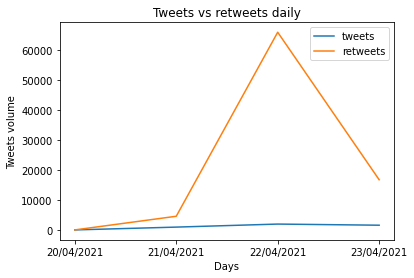

[2, 940, 1953, 1573]
[3, 4562, 66002, 16756]


In [47]:
def DailyTweetsAndRetweets(start, end):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    current_date = start
    today = ''
    list_days = []
    list_day_tweet_count = []
    list_day_retweet_count = []
    while current_date != end:
        # { "referenced_tweets.type" : "retweeted", { "username" : { "$regex" : current_date } } }
        today = DayMonthYearToPetition(current_date) + ".*"
        tweets_not_retweets = len(list(mytweets.find( {"$and": [ { "referenced_tweets.type" : {"$ne": "retweeted"} }, { "created_at" : { "$regex" : today }} ] } )))
        tweets_retweets = len(list(mytweets.find( {"$and": [ {"referenced_tweets.type" : "retweeted"}, {"created_at" : { "$regex" : today }} ] } )))
        
        list_days.append(current_date)
        list_day_tweet_count.append(tweets_not_retweets)
        list_day_retweet_count.append(tweets_retweets)
        current_date = NextDate(current_date)
    #print plot here
    plt.plot(list_days, list_day_tweet_count, label = "tweets")
    # plotting the line 2 points 
    plt.plot(list_days, list_day_retweet_count, label = "retweets")

    # naming the x axis
    plt.xlabel('Days')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title('Tweets vs retweets daily')
    # show a legend on the plot
    plt.legend()
    # function to show the plot
    plt.show()
    print(list_day_tweet_count)
    print(list_day_retweet_count)
    
DailyTweetsAndRetweets("20/04/2021", "24/04/2021")

### Top-10 most tweeted and retweeted keywords.

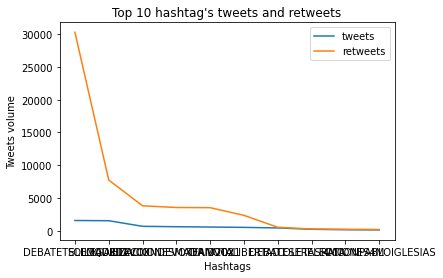

[1558, 1526, 669, 610, 561, 508, 424, 219, 149, 121]
[30309, 7741, 3806, 3545, 3515, 2346, 519, 259, 223, 182]


In [64]:
def Top10MostTweetsAndRetweets():
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    
    hashtag_retweet = {}
    hashtag_tweet = {}

    list_hashtags = []
    list_hashtag_retweet = []
    list_hashtag_tweet = []
    hashtags_list = []
    hashtag = ''
    
    f =  open("./hashtags.txt", "r")
    while True:
        # read line
        try:
            hashtag = f.readline()
            if (hashtag == "") :
                break
        except:
            # datetime object containing current date and time
            now = datetime.datetime.now()
            # dd/mm/YY H:M:S
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            errorlog = open("./errorlog" + d1 + ".txt", "a")
            errorlog.write("Fallo al leer el fichero hashtags.txt " + dt_string + "\n")
            errorlog.close()

        hashtag = hashtag.rstrip('\n')
        hashtag = hashtag.replace('#', '')
        hashtags_list.append(hashtag.upper())
        
    f.close()
    
    for h in hashtags_list:
        tweets_not_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : {"$ne": "retweeted"} }, { "hashtag": { "$elemMatch": { "$eq": h } } } ] } )))
        tweets_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : "retweeted"}, {"hashtag": { "$elemMatch": { "$eq": h } } } ] } )))
        
        hashtag_retweet[h] = tweets_retweets
        hashtag_tweet[h] = tweets_not_retweets
                        
    sort_hashtag_retweet = sorted(hashtag_retweet.items(), key=lambda x: x[1], reverse=True)
    sort_hashtag_tweet = sorted(hashtag_tweet.items(), key=lambda x: x[1], reverse=True)
    
    for node in sort_hashtag_retweet[0:10]:
        list_hashtag_retweet.append(node[1])
    
    for node in sort_hashtag_tweet[0:10]:
        list_hashtag_tweet.append(node[1])
        list_hashtags.append(node[0])
        
    #print plot here
    plt.plot(list_hashtags, list_hashtag_tweet, label = "tweets")
    # plotting the line 2 points 
    plt.plot(list_hashtags, list_hashtag_retweet, label = "retweets")

    # naming the x axis
    plt.xlabel('Hashtags')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 10 hashtag's tweets and retweets")
    # show a legend on the plot
    plt.legend()
    # function to show the plot
    plt.show()
    print(list_hashtag_tweet)
    print(list_hashtag_retweet)
    
Top10MostTweetsAndRetweets()

### Word clouds with the top-100 most popular words in numbers of tweets and retweets.

### Keywords popularity over the weeks.

### Distributions of the number of tweets and retweets per Twitter account.

### Top-5 most active verified user accounts.

### Example tweets with emojis.

### Contrasting sentiment score of users towards the keywords over the weeks.

### Co-occurrence networks for tweets and retweets.

### Top-20 LIWC attributes extracted from the collected tweets and retweets.